In [1]:
import copy
import csv
import functools
import glob
import os
import logging
import gzip

import collections
import datetime
import gc
import time

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

from collections import namedtuple

import SimpleITK as sitk
import numpy as np

import torch
from torch.utils.data import Dataset

from functools import lru_cache
from diskcache import FanoutCache, Disk
from diskcache import Disk, core
from diskcache.core import io
from io import BytesIO
from diskcache.core import MODE_BINARY
from cassandra.cqltypes import BytesType

## Data cache

In [2]:
class GzipDisk(Disk):
    def store(self, value, read, key=None):
        """
        Override from base class diskcache.Disk.

        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.

        :param value: value to convert
        :param bool read: True when value is file-like object
        :return: (size, mode, filename, value) tuple for Cache table
        """
        # pylint: disable=unidiomatic-typecheck
        if type(value) is BytesType:
            if read:
                value = value.read()
                read = False

            str_io = BytesIO()
            gz_file = gzip.GzipFile(mode='wb', compresslevel=1, fileobj=str_io)

            for offset in range(0, len(value), 2**30):
                gz_file.write(value[offset:offset+2**30])
            gz_file.close()

            value = str_io.getvalue()

        return super(GzipDisk, self).store(value, read)


    def fetch(self, mode, filename, value, read):
        """
        Override from base class diskcache.Disk.

        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.

        :param int mode: value mode raw, binary, text, or pickle
        :param str filename: filename of corresponding value
        :param value: database value
        :param bool read: when True, return an open file handle
        :return: corresponding Python value
        """
        value = super(GzipDisk, self).fetch(mode, filename, value, read)

        if mode == MODE_BINARY:
            str_io = BytesIO(value)
            gz_file = gzip.GzipFile(mode='rb', fileobj=str_io)
            read_csio = BytesIO()

            while True:
                uncompressed_data = gz_file.read(2**30)
                if uncompressed_data:
                    read_csio.write(uncompressed_data)
                else:
                    break

            value = read_csio.getvalue()

        return value

def getCache(scope_str):
    return FanoutCache('/Users/alexeyfilichkin/Desktop/PyTorch/part2/cache/' + scope_str,
                       disk=GzipDisk,
                       shards=64,
                       timeout=1,
                       size_limit=3e11,
                       # disk_min_file_size=2**20,
                       )

In [3]:
log = logging.getLogger(__name__)
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

In [4]:
raw_cache = getCache('part2ch10_raw')

In [5]:
CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    'isNodule_bool, diameter_mm, series_uid, center_xyz',
)

## Transform millimeters to voksels

In [6]:
IrcTuple = collections.namedtuple('IrcTuple', ['index', 'row', 'col'])
XyzTuple = collections.namedtuple('XyzTuple', ['x', 'y', 'z'])

In [7]:
def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    cri_a = np.array(coord_irc)[::-1]
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coords_xyz = (direction_a @ (cri_a * vxSize_a)) + origin_a
    # coords_xyz = (direction_a @ (idx * vxSize_a)) + origin_a
    return XyzTuple(*coords_xyz)

def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coord_a = np.array(coord_xyz)
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)
    return IrcTuple(int(cri_a[2]), int(cri_a[1]), int(cri_a[0]))
def importstr(module_str, from_=None):
    """
    >>> importstr('os')
    <module 'os' from '.../os.pyc'>
    >>> importstr('math', 'fabs')
    <built-in function fabs>
    """
    if from_ is None and ':' in module_str:
        module_str, from_ = module_str.rsplit(':')

    module = __import__(module_str)
    for sub_str in module_str.split('.')[1:]:
        module = getattr(module, sub_str)

    if from_:
        try:
            return getattr(module, from_)
        except:
            raise ImportError('{}.{}'.format(module_str, from_))
    return module

def prhist(ary, prefix_str=None, **kwargs):
    if prefix_str is None:
        prefix_str = ''
    else:
        prefix_str += ' '

    count_ary, bins_ary = np.histogram(ary, **kwargs)
    for i in range(count_ary.shape[0]):
        print("{}{:-8.2f}".format(prefix_str, bins_ary[i]), "{:-10}".format(count_ary[i]))
    print("{}{:-8.2f}".format(prefix_str, bins_ary[-1]))

def enumerateWithEstimate(
        iter,
        desc_str,
        start_ndx=0,
        print_ndx=4,
        backoff=None,
        iter_len=None,
):
    if iter_len is None:
        iter_len = len(iter)

    if backoff is None:
        backoff = 2
        while backoff ** 7 < iter_len:
            backoff *= 2

    assert backoff >= 2
    while print_ndx < start_ndx * backoff:
        print_ndx *= backoff

    log.warning("{} ----/{}, starting".format(
        desc_str,
        iter_len,
    ))
    start_ts = time.time()
    for (current_ndx, item) in enumerate(iter):
        yield (current_ndx, item)
        if current_ndx == print_ndx:
            # ... <1>
            duration_sec = ((time.time() - start_ts)
                            / (current_ndx - start_ndx + 1)
                            * (iter_len-start_ndx)
                            )

            done_dt = datetime.datetime.fromtimestamp(start_ts + duration_sec)
            done_td = datetime.timedelta(seconds=duration_sec)

            log.info("{} {:-4}/{}, done at {}, {}".format(
                desc_str,
                current_ndx,
                iter_len,
                str(done_dt).rsplit('.', 1)[0],
                str(done_td).rsplit('.', 1)[0],
            ))

            print_ndx *= backoff

        if current_ndx + 1 == start_ndx:
            start_ts = time.time()

    log.warning("{} ----/{}, done at {}".format(
        desc_str,
        iter_len,
        str(datetime.datetime.now()).rsplit('.', 1)[0],
    ))

## Merge anntotations and candidates data

In [8]:
@functools.lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=True):
    # We construct a set with all series_uids that are present on disk.
    # This will let us use the data, even if we haven't downloaded all of
    # the subsets yet.
    mhd_list = glob.glob('/Users/alexeyfilichkin/Desktop/PyTorch/part2/luna/subset*/*.mhd')
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}

    diameter_dict = {}
    with open('/Users/alexeyfilichkin/Desktop/PyTorch/part2/luna/annotations.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])

            diameter_dict.setdefault(series_uid, []).append(
                (annotationCenter_xyz, annotationDiameter_mm)
            )

    candidateInfo_list = []
    with open('/Users/alexeyfilichkin/Desktop/PyTorch/part2/luna/candidates.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]

            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue

            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

            candidateDiameter_mm = 0.0
            for annotation_tup in diameter_dict.get(series_uid, []):
                annotationCenter_xyz, annotationDiameter_mm = annotation_tup
                for i in range(3):
                    delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])
                    if delta_mm > annotationDiameter_mm / 4:
                        break
                else:
                    candidateDiameter_mm = annotationDiameter_mm
                    break

            candidateInfo_list.append(CandidateInfoTuple(
                isNodule_bool,
                candidateDiameter_mm,
                series_uid,
                candidateCenter_xyz,
            ))

    candidateInfo_list.sort(reverse=True)
    return candidateInfo_list

## Data upload

In [9]:
class Ct:
    def __init__(self, series_uid):
        mhd_path = glob.glob(
            '/Users/alexeyfilichkin/Desktop/PyTorch/part2/luna/subset*/{}.mhd'.format(series_uid)
        )[0]

        ct_mhd = sitk.ReadImage(mhd_path)
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

        # CTs are natively expressed in https://en.wikipedia.org/wiki/Hounsfield_scale
        # HU are scaled oddly, with 0 g/cc (air, approximately) being -1000 and 1 g/cc (water) being 0.
        # The lower bound gets rid of negative density stuff used to indicate out-of-FOV
        # The upper bound nukes any weird hotspots and clamps bone down
        ct_a.clip(-1000, 1000, ct_a)

        self.series_uid = series_uid
        self.hu_a = ct_a

        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)

    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(
            center_xyz,
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction_a,
        )

        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])

            assert center_val >= 0 and center_val < self.hu_a.shape[axis], repr([self.series_uid, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis])

            if start_ndx < 0:
                # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
                #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
                start_ndx = 0
                end_ndx = int(width_irc[axis])

            if end_ndx > self.hu_a.shape[axis]:
                # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
                #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])

            slice_list.append(slice(start_ndx, end_ndx))

        ct_chunk = self.hu_a[tuple(slice_list)]

        return ct_chunk, center_irc


## Catche with getCtRawCandidate function

In [10]:
@functools.lru_cache(1, typed=True)
def getCt(series_uid):
    return Ct(series_uid)

@raw_cache.memoize(typed=True)
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc

## Dataset creation

In [11]:
class LunaDataset(Dataset):
    def __init__(self,
                 val_stride=0,
                 isValSet_bool=None,
                 series_uid=None,
            ):
        self.candidateInfo_list = copy.copy(getCandidateInfoList())

        if series_uid:
            self.candidateInfo_list = [
                x for x in self.candidateInfo_list if x.series_uid == series_uid
            ]
# data split for train and validation
        
        if isValSet_bool:
            assert val_stride > 0, val_stride
            self.candidateInfo_list = self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
        elif val_stride > 0:
            del self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list

        log.info("{!r}: {} {} samples".format(
            self,
            len(self.candidateInfo_list),
            "validation" if isValSet_bool else "training",
        ))

    def __len__(self):
        return len(self.candidateInfo_list)

    def __getitem__(self, ndx):
        candidateInfo_tup = self.candidateInfo_list[ndx]
        width_irc = (32, 48, 48)

        candidate_a, center_irc = getCtRawCandidate(
            candidateInfo_tup.series_uid,
            candidateInfo_tup.center_xyz,
            width_irc,
        )

        candidate_t = torch.from_numpy(candidate_a)
        candidate_t = candidate_t.to(torch.float32)
        candidate_t = candidate_t.unsqueeze(0)

        pos_t = torch.tensor([
                not candidateInfo_tup.isNodule_bool,
                candidateInfo_tup.isNodule_bool
            ],
            dtype=torch.long,
        )

        return (
            candidate_t,
            pos_t,
            candidateInfo_tup.series_uid,
            torch.tensor(center_irc),
        )

In [12]:
LunaDataset()[101]

(tensor([[[[ -367.,  -393.,  -480.,  ...,   480.,   439.,   470.],
           [ -578.,  -677.,  -947.,  ...,    36.,    48.,   444.],
           [ -853.,  -927., -1000.,  ...,  -878.,  -508.,   305.],
           ...,
           [  -42.,    30.,   -12.,  ...,  -758.,  -865.,  -912.],
           [  -86.,   108.,   105.,  ...,  -848.,  -758.,  -948.],
           [ -191.,  -153.,   -19.,  ...,  -631.,  -651.,  -723.]],
 
          [[ -365.,  -225.,  -527.,  ...,   119.,   263.,   456.],
           [ -772.,  -871.,  -975.,  ...,  -868.,  -737.,  -283.],
           [ -913.,  -890., -1000.,  ..., -1000.,  -823.,  -366.],
           ...,
           [   66.,  -208.,  -258.,  ...,  -984., -1000., -1000.],
           [   57.,   102.,   -98.,  ...,  -652.,  -707.,  -801.],
           [   89.,    21.,    13.,  ...,  -970.,  -872.,  -702.]],
 
          [[ -430.,  -669.,  -814.,  ...,    27.,    82.,   216.],
           [ -472.,  -613.,  -838.,  ...,  -249.,    85.,    23.],
           [ -967.,  -80

In [13]:
candidateInfo_list = getCandidateInfoList(requireOnDisk_bool=False)
positiveInfo_list = [x for x in candidateInfo_list if x[0]]
diameter_list = [x[1] for x in positiveInfo_list]

In [14]:
for i in range(0, len(diameter_list), 100):
    print('{:4}  {:4.1f} mm'.format(i, diameter_list[i]))

   0  32.3 mm
 100  17.7 mm
 200  13.0 mm
 300  10.0 mm
 400   8.2 mm
 500   7.0 mm
 600   6.3 mm
 700   5.7 mm
 800   5.1 mm
 900   4.7 mm
1000   4.0 mm
1100   0.0 mm
1200   0.0 mm
1300   0.0 mm


## Data visualization

In [15]:
%matplotlib inline

In [16]:
clim=(-1000.0, 300)

def findPositiveSamples(start_ndx=0, limit=100):
    ds = LunaDataset()

    positiveSample_list = []
    for sample_tup in ds.candidateInfo_list:
        if sample_tup.isNodule_bool:
            print(len(positiveSample_list), sample_tup)
            positiveSample_list.append(sample_tup)

        if len(positiveSample_list) >= limit:
            break

    return positiveSample_list

def showCandidate(series_uid, batch_ndx=None, **kwargs):
    ds = LunaDataset(series_uid=series_uid, **kwargs)
    pos_list = [i for i, x in enumerate(ds.candidateInfo_list) if x.isNodule_bool]

    if batch_ndx is None:
        if pos_list:
            batch_ndx = pos_list[0]
        else:
            print("Warning: no positive samples found; using first negative sample.")
            batch_ndx = 0

    ct = Ct(series_uid)
    ct_t, pos_t, series_uid, center_irc = ds[batch_ndx]
    ct_a = ct_t[0].numpy()

    fig = plt.figure(figsize=(30, 50))

    group_list = [
        [9, 11, 13],
        [15, 16, 17],
        [19, 21, 23],
    ]

    subplot = fig.add_subplot(len(group_list) + 2, 3, 1)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[int(center_irc[0])], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 2)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,int(center_irc[1])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 3)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,:,int(center_irc[2])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 4)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[ct_a.shape[0]//2], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 5)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,ct_a.shape[1]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 6)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,:,ct_a.shape[2]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    for row, index_list in enumerate(group_list):
        for col, index in enumerate(index_list):
            subplot = fig.add_subplot(len(group_list) + 2, 3, row * 3 + col + 7)
            subplot.set_title('slice {}'.format(index), fontsize=30)
            for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
                label.set_fontsize(20)
            plt.imshow(ct_a[index], clim=clim, cmap='gray')


    print(series_uid, batch_ndx, bool(pos_t[0]), pos_list)

In [17]:
noduleSample_list = findPositiveSamples()

0 CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(67.61451718, 85.02525992, -109.8084416))
1 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(47.90350511, 37.60442008, -99.93417567))
2 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(44.19, 37.79, -107.01))
3 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(40.69, 32.19, -97.15))
4 CandidateInfoTuple(isNodule_bool=True, diameter_mm=27.44242293, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311', center_xyz=(-45.29440163, 74.86925386, -97.52812481))
5 CandidateInfoTuple(isNodule_bool=True, dia

In [18]:
series_uid = noduleSample_list[11][2]

1.3.6.1.4.1.14519.5.2.1.6279.6001.183982839679953938397312236359 0 False [0, 1, 2, 3, 4, 5, 6]


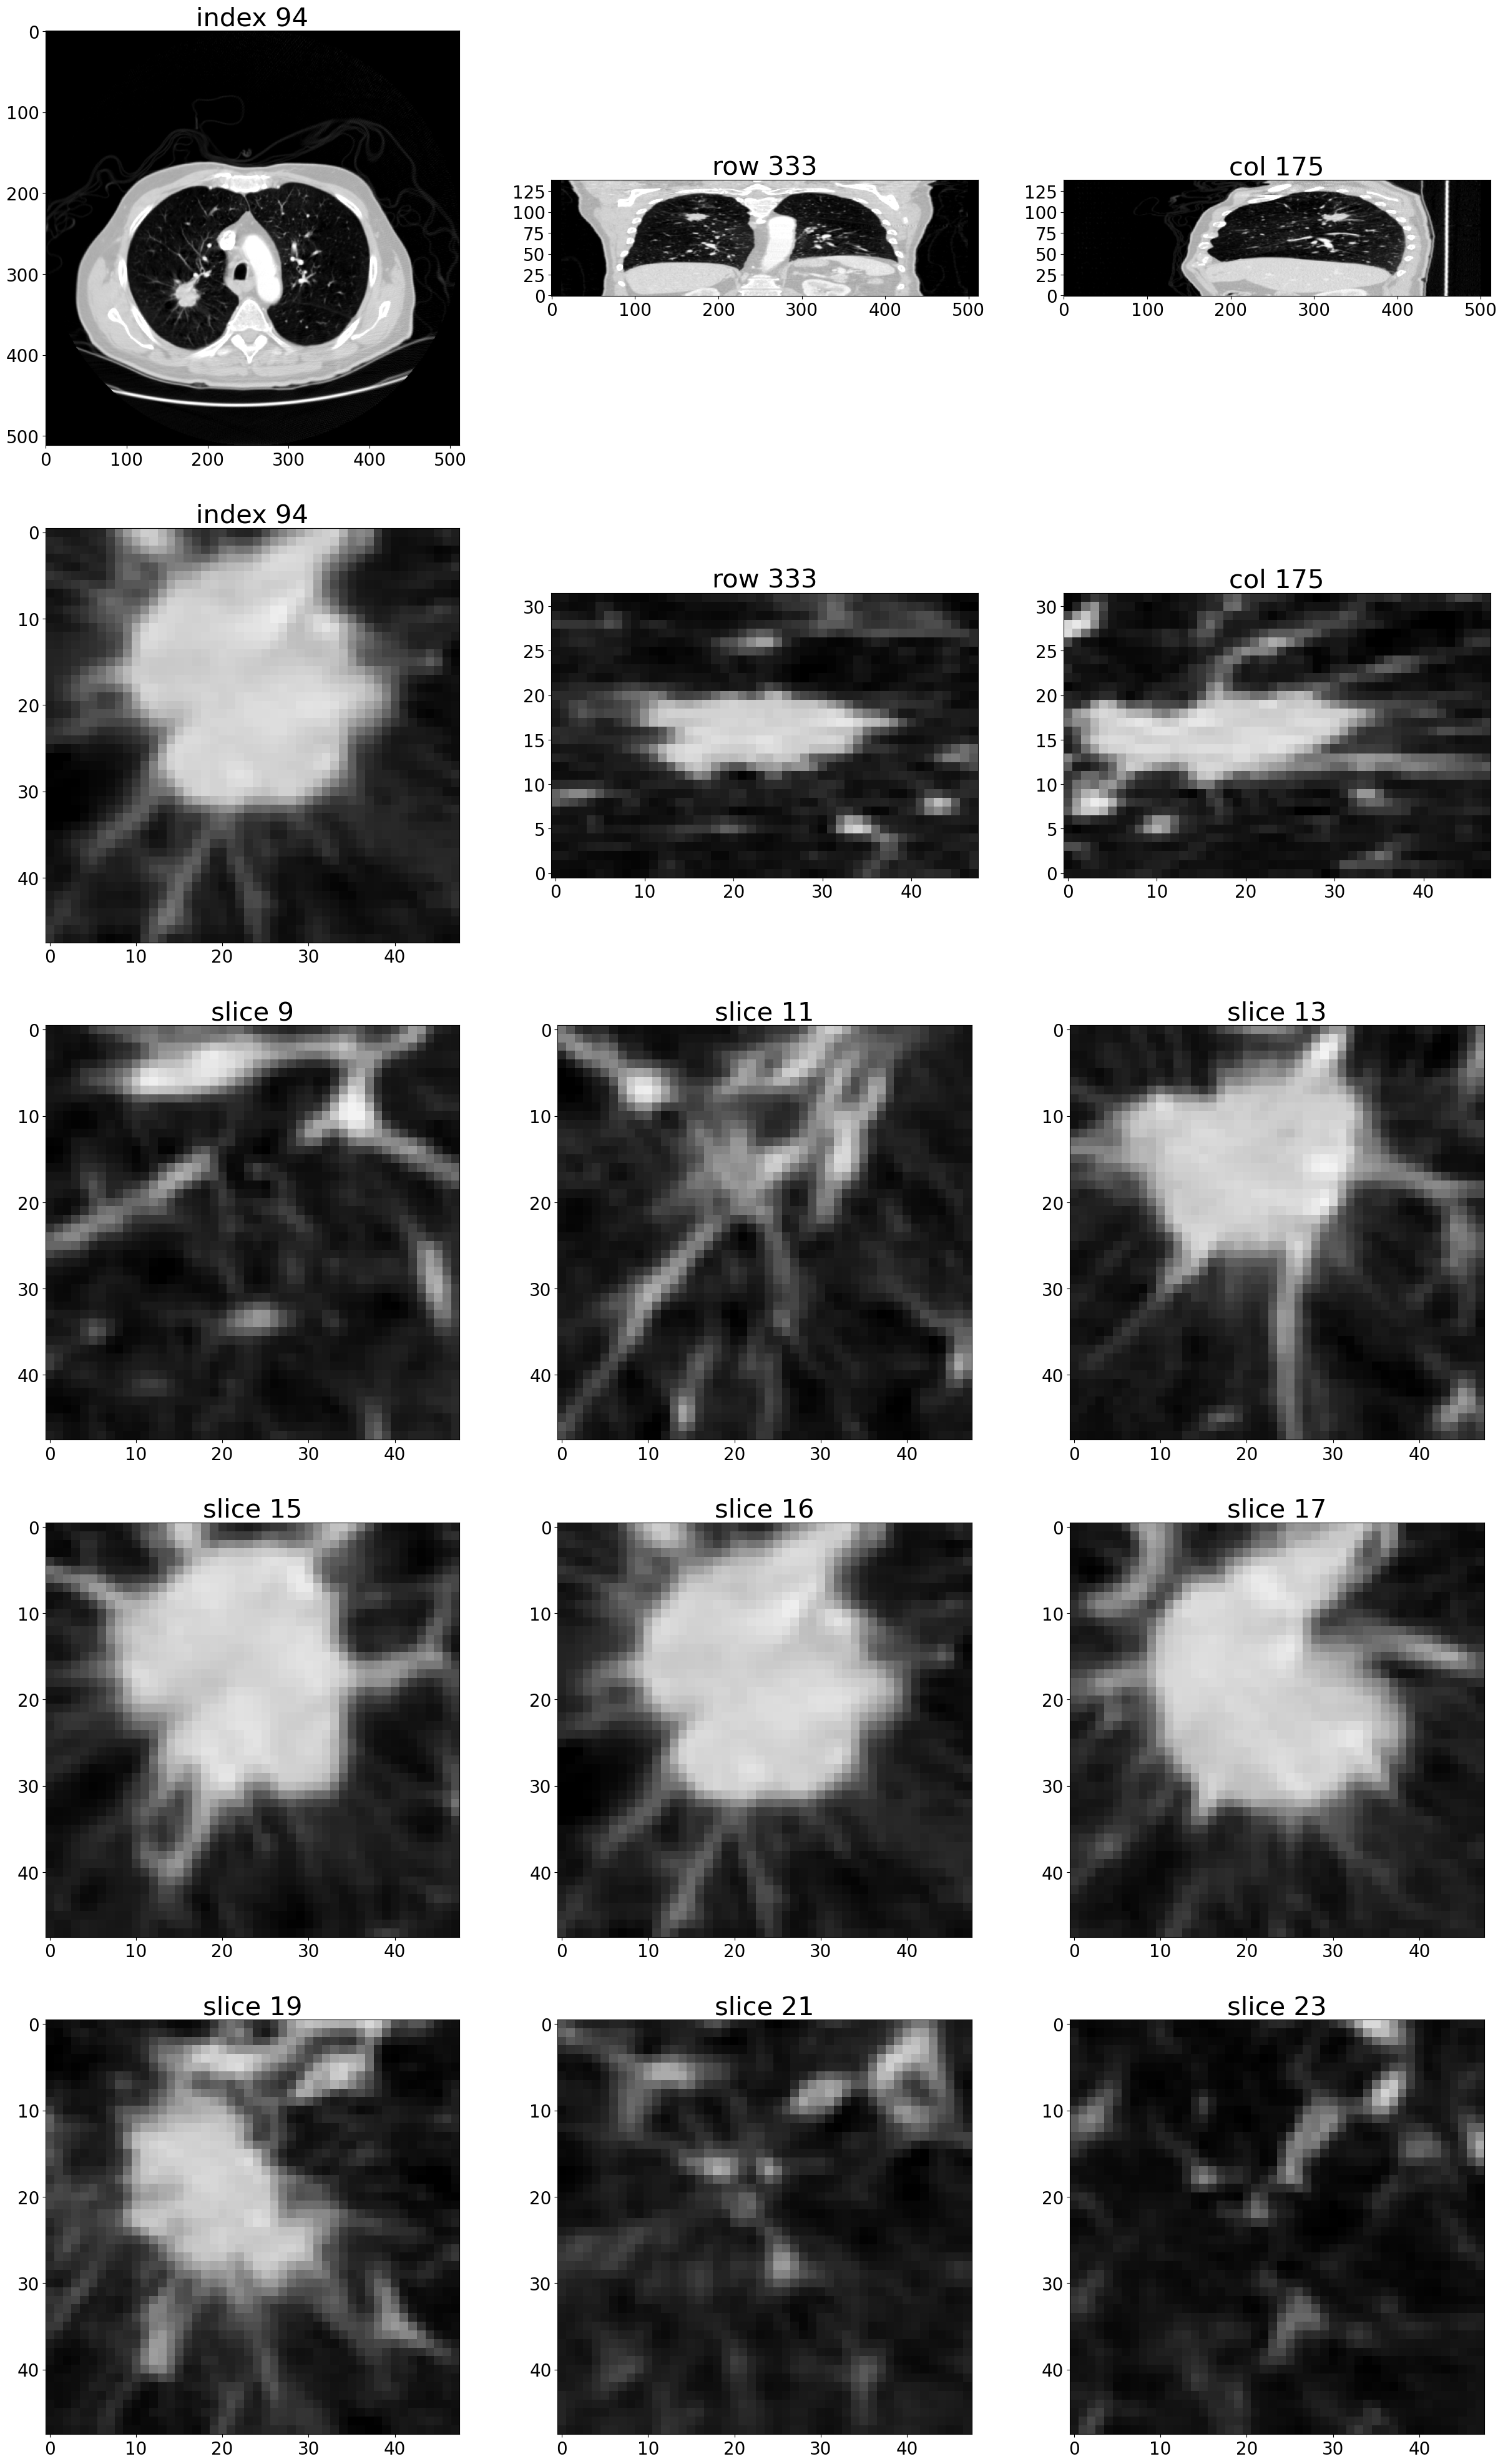

In [19]:
showCandidate(series_uid)